This a brief tutorial to use HDP-GPC, a dynamic clustering library. 
As a summary of the objectives of this notebook:
1. Learn to load some public data and learn how compute the initial statistics.
2. Learn to define the model and check each one of the hyperparameters' configuration.
3. Learn to execute inference and how this can be tuned.
4. Learn how to plot the results and study the dynamic parameters.

We should first import the main packages to deal with the data:

In [1]:
import numpy as np
import torch
import os

Now we can load the data, to illustrate this example we are going to reduce the data to examples from 1700 to 1950.

In [2]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(cwd, 'data', 'mitbih')
data = np.load(os.path.join(data_path, '100.npy'))
labels = np.load(os.path.join(data_path, '100_labels.npy'))

print("Shape of the data: ")
print(data.shape)
data = data[1700:1950]
labels = labels[1700:1950]
num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(2272, 90, 2)


The data dimensions correspond with [number of examples, number of observations, number of outputs]. Let's check how looks this data:

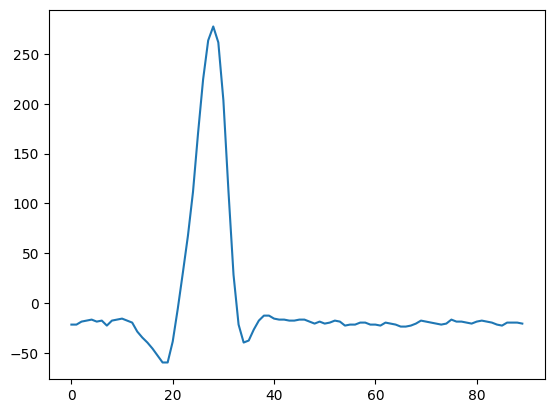

In [3]:
import matplotlib.pyplot as plt

plt.plot(data[0,:,0])
plt.show()

As we can see, it corresponds to a heartbeat. This is the kind of patterns we want to cluster over the record.
To compute the initial statistics we are going to use the observation variance and the 1-step rolled variance.
For that, we have a method in the get_data class, where we can choose the batch to compute this statistics.

In [4]:
from hdpgpc.get_data import compute_estimators_LDS

std, std_dif = compute_estimators_LDS(data, n_f=50)
print("Variance: ", str(std))
print("1-step variance: ", str(std_dif))

Variance:  15.507754619329432
1-step variance:  21.86093258151018


As we can see, the 1-step variance is higher than the variance, which indicates a slight dynamic behaviour.

Now we can define the HDP-GPC model. 

The hyperparameters can be directly estimated from the previously computed estimators. As a standard an initial M has to be chosen, as a default, it is chosen as M=2 as the model computes the needed number of clusters as it progresses in the inference.


In [5]:
M = 2
sigma = [std * 1.0] * M
bound_sigma_ = (std * 0.1, std * 0.2)
gamma = [std_dif * 1.0] * M
bound_gamma = (std_dif * 0.1, std_dif * 1.0)

We can also define the kernel parameters, in this case we are taking outputscale = 300.0 as is the mean amplitude found on a standard record of ECG. Also, we are choosing ini_legthscale = 1.0 as a standard value. Both can be tuned, but they do not have a critical impact on the inference because they are optimized in terms of Maximum-Likelihood.

In [6]:
outputscale_ = 300.0
ini_lengthscale = 3.0
bound_lengthscale = (1.0, 20.0)

Also, we have to define the time indexes where the observations had been taken, which is x_train. In this case it can be as simple as a range of the same length of the observations, but it can differ along the samples. On the other hand, we have to define x_basis, which is the time index basis where the LDS is going to be computed (it fix the dimension of the LDS) If desired, the x_basis can be reduced to be a set of inducing points. If this dimensional reduction is applied it should be reflected in the option parameter inducing_points=True. 

In [7]:
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
x_basis = np.atleast_2d(np.arange(l, L, 1, dtype=np.float64)).T
x_train = np.atleast_2d(np.arange(l, L, dtype=np.float64)).T
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False

Additionally, we can also define the warp GP hyperparameters and time indexes. 

In [8]:
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(l, L, 2, dtype=np.float64)).T

Finally, with these parameters we can define the HDP-GPC. 
There exist a lot of configuration parameters that can be combined in this model, to check the options and the relevance of these configuration options go to the Documentation (in progress).

In terms of define the model, we should consider the inference method we want to apply because each one have their restrictions (by now).

1. In first place we have the online inference, where we can include one sample at a time and let the model cluster it. By now, the online inference only works with one output signal, but it is going to be extended soon. That's why we choose n_outputs=1.

In [9]:
import hdpgpc.GPI_HDP as hdpgp

sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma_, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, estimation_limit=30)

D:\Programs\Workspaces\spyder-workspace\HDP-GPC\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can revise the priors that had been defined for our model.  The cluster list of GP-LDS is generated inside the model, indexes as gpmodels[n_output][n_cluster]. We can plot the zero-knowledge cluster.

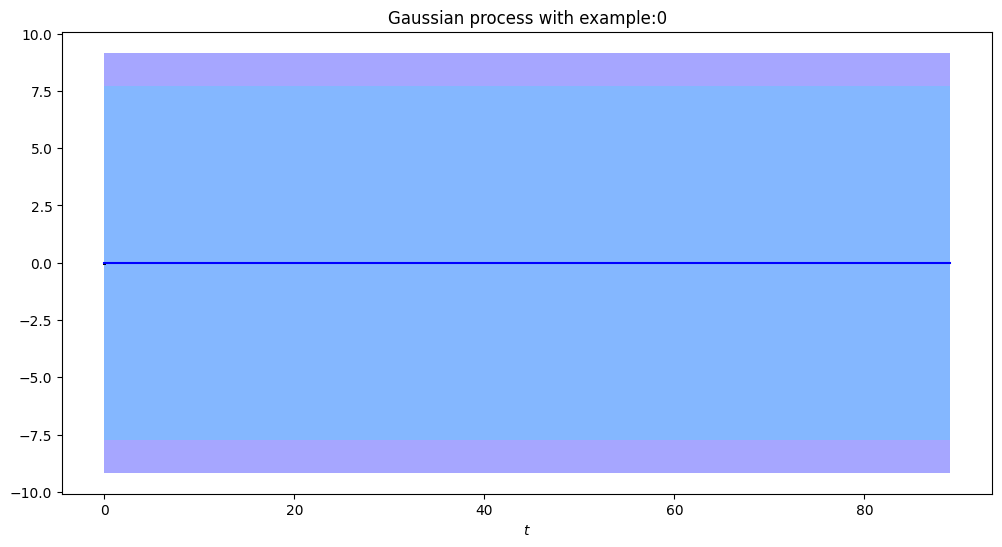

In [10]:
sw_gp.gpmodels[0][0].plot_last(0)

In [11]:
data_ = data[:,:,[0]]
sw_gp.include_sample(x_train, data_[0], with_warp=warp)

Main model chosen: 1

 Fitting_GP: 

Iter 1/4000 - Loss: 655.791
Iter 501/4000 - Loss: 42.970
Iter 1001/4000 - Loss: 30.743
Iter 1501/4000 - Loss: 25.020
Iter 2001/4000 - Loss: 21.463
Iter 2501/4000 - Loss: 18.943
Iter 3001/4000 - Loss: 17.015
Iter 3501/4000 - Loss: 15.467


Parameter name: likelihood.noise_covar.raw_noise           value = [4.6671812]
Parameter name: mean_module.raw_constant                   value = -1.058603266036602
Parameter name: covar_module.raw_outputscale               value = 44.374142893583155
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[2.44551306]]


Now the first example has been included in the model. 
We can check some parameters to be sure the sample has been added:

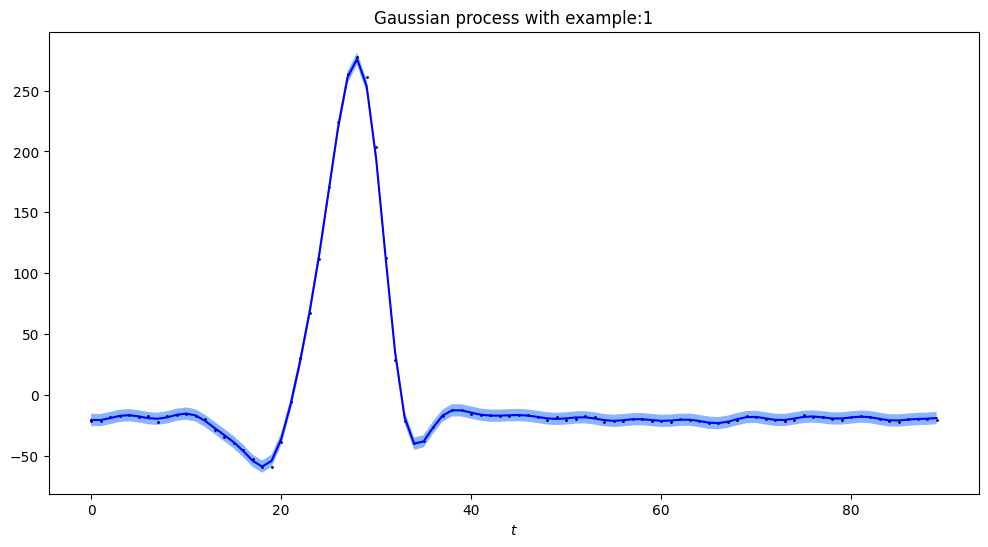

In [12]:
sw_gp.gpmodels[0][0].plot_last(0)

As we can see, the sample had been added successfully and the GP performed regression over it. Now we can include more samples, in this case, we are adding 100 to check how fast is the computation without warp component.

In [13]:
import time

for j, d in enumerate(data_[1:200]):
    start_time = time.time()
    print("Sample:", j+1, "/", str(data_.shape[0]-1), "label:", labels[j+1])
    sw_gp.include_sample(x_train, d, with_warp=warp)
    print("Time --- %s seconds ---" % (time.time() - start_time))

Sample: 1 / 249 label: N
Main model chosen: 1
Time --- 0.13663363456726074 seconds ---
Sample: 2 / 249 label: N
Main model chosen: 1
Time --- 0.032912254333496094 seconds ---
Sample: 3 / 249 label: N
Main model chosen: 1
Time --- 0.04388308525085449 seconds ---
Sample: 4 / 249 label: N
Main model chosen: 1
Time --- 0.03690052032470703 seconds ---
Sample: 5 / 249 label: N
Birth of new model:  2
Main model chosen: 2

 Fitting_GP: 

Iter 1/4000 - Loss: 767.252
Iter 501/4000 - Loss: 45.176
Iter 1001/4000 - Loss: 32.566
Iter 1501/4000 - Loss: 26.563
Iter 2001/4000 - Loss: 22.788
Iter 2501/4000 - Loss: 20.091
Iter 3001/4000 - Loss: 18.018
Iter 3501/4000 - Loss: 16.347


Parameter name: likelihood.noise_covar.raw_noise           value = [4.86802518]
Parameter name: mean_module.raw_constant                   value = -1.3498767577669495
Parameter name: covar_module.raw_outputscale               value = 42.43683224988738
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[2.6672

The clustering has generated two clusters. Let's revise them:

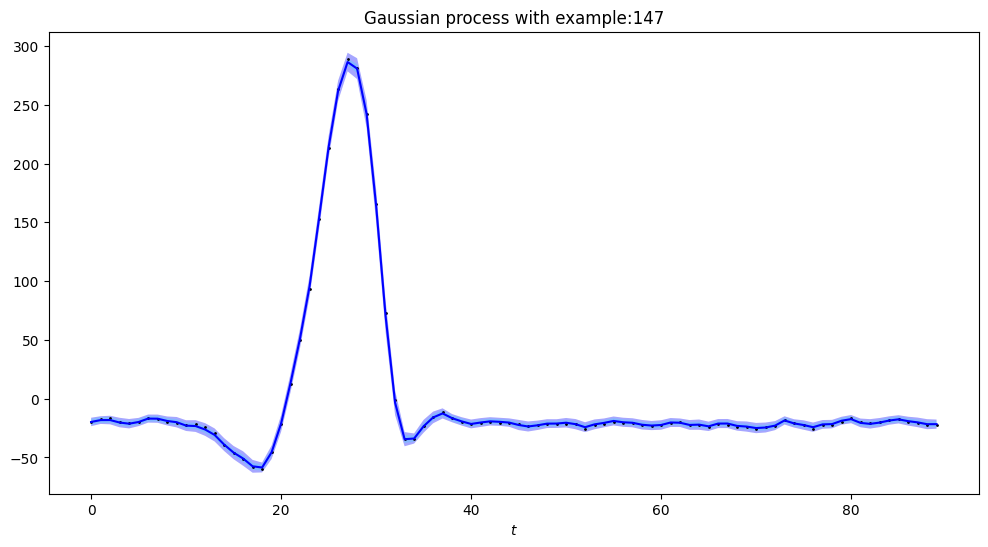

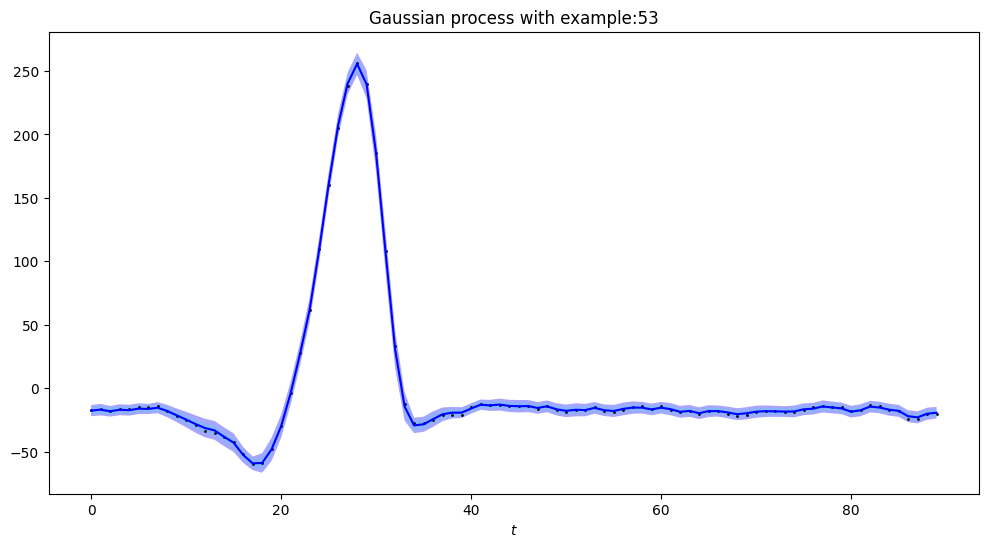

In [14]:
sw_gp.gpmodels[0][0].plot_last(0)
sw_gp.gpmodels[0][1].plot_last(0)

Even if we want to revise the beats included we can use the util_plot methods. Here the difference between groups is clearer:

Model 1 : MainModel: N : [A-2,N-145]
Model 2 : MainModel: N : [N-53]
Model 3  : []
Classification error:  2.0 / 200 -- 0.01


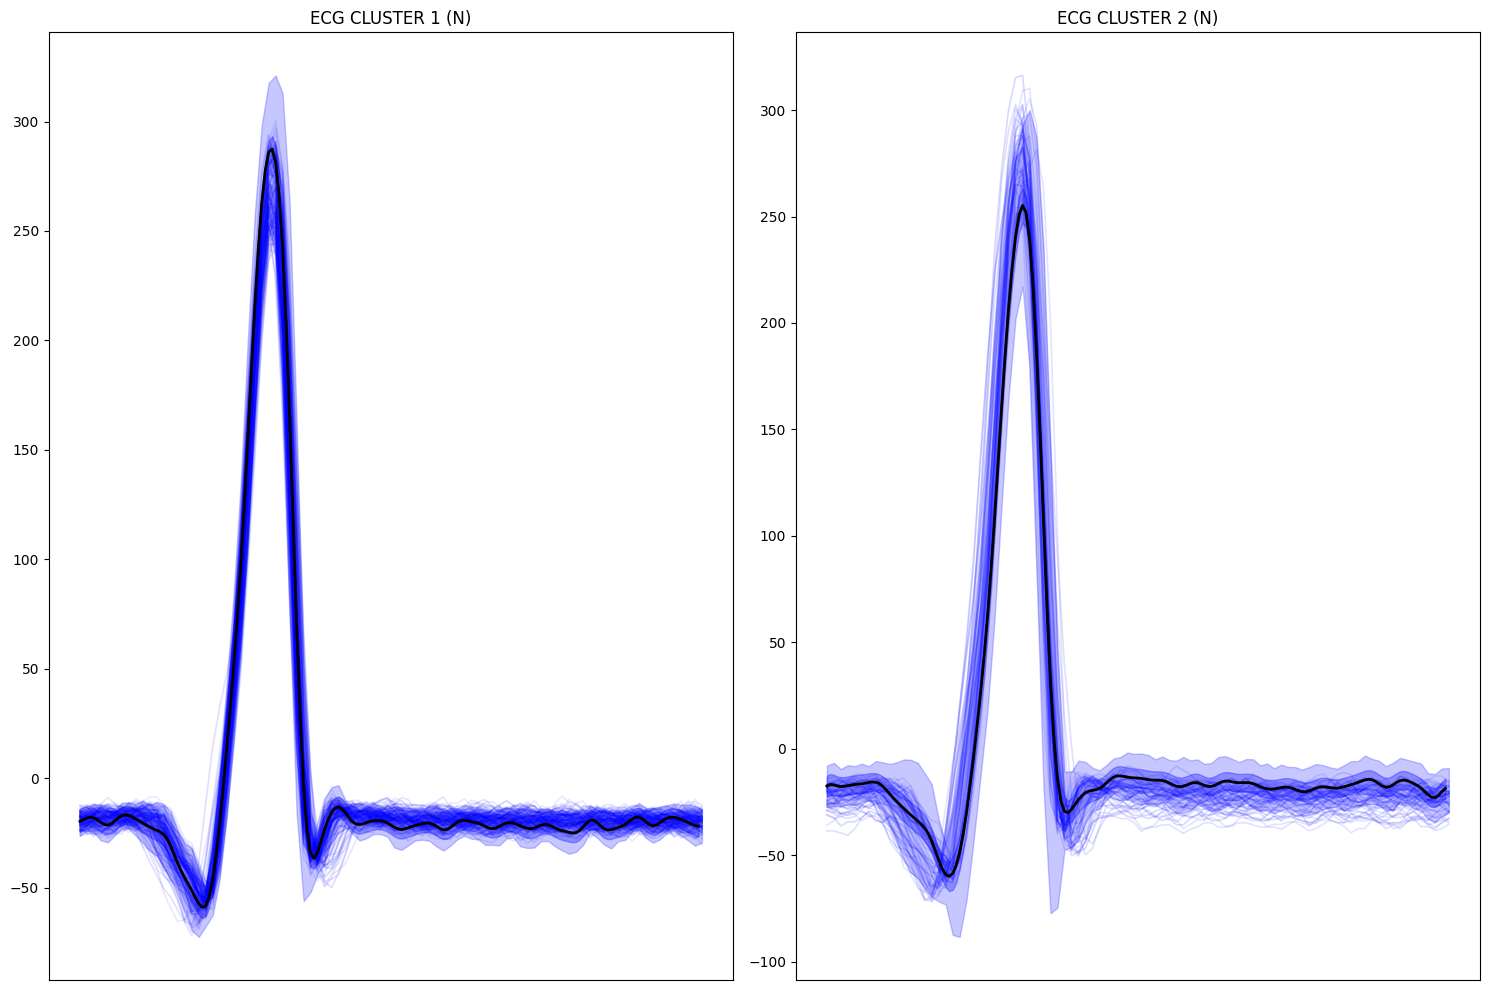

In [15]:
from hdpgpc.util_plots import print_results, plot_models_plotly

main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

If we try to include the examples from 1900 to 1950, knowing that a ventricular beat exist among them, we are going to check if the model generates a new group.

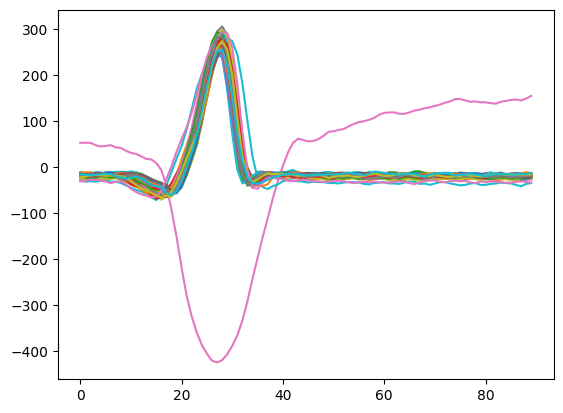

In [16]:
plt.plot(data_[200:,:,0].T)
plt.show()


In [17]:

for j, d in enumerate(data_[200:]):
    start_time = time.time()
    print("Sample:", j + 200, "/", str(data_.shape[0]-1), "label:", labels[j+200])
    sw_gp.include_sample(x_train, d, with_warp=warp)
    print("Time --- %s seconds ---" % (time.time() - start_time))

Sample: 200 / 249 label: N
Main model chosen: 1
Time --- 0.14959716796875 seconds ---
Sample: 201 / 249 label: N
Main model chosen: 2
Time --- 0.12865543365478516 seconds ---
Sample: 202 / 249 label: N
Main model chosen: 1
Time --- 0.09627866744995117 seconds ---
Sample: 203 / 249 label: N
Main model chosen: 1
Time --- 0.12466597557067871 seconds ---
Sample: 204 / 249 label: N
Main model chosen: 1
Time --- 0.11170125007629395 seconds ---
Sample: 205 / 249 label: N
Main model chosen: 2
Time --- 0.1376349925994873 seconds ---
Sample: 206 / 249 label: V
Birth of new model:  3
Main model chosen: 3

 Fitting_GP: 

Iter 1/4000 - Loss: 4298.585
Iter 501/4000 - Loss: 154.029
Iter 1001/4000 - Loss: 111.261
Iter 1501/4000 - Loss: 90.373
Iter 2001/4000 - Loss: 77.137
Iter 2501/4000 - Loss: 67.646
Iter 3001/4000 - Loss: 60.325
Iter 3501/4000 - Loss: 54.402


Parameter name: likelihood.noise_covar.raw_noise           value = [4.8145359]
Parameter name: mean_module.raw_constant                   val

Model 1 : MainModel: N : [A-2,N-181]
Model 2 : MainModel: N : [N-66]
Model 3 : MainModel: V : [V-1]
Model 4  : []
Classification error:  2.0 / 250 -- 0.008


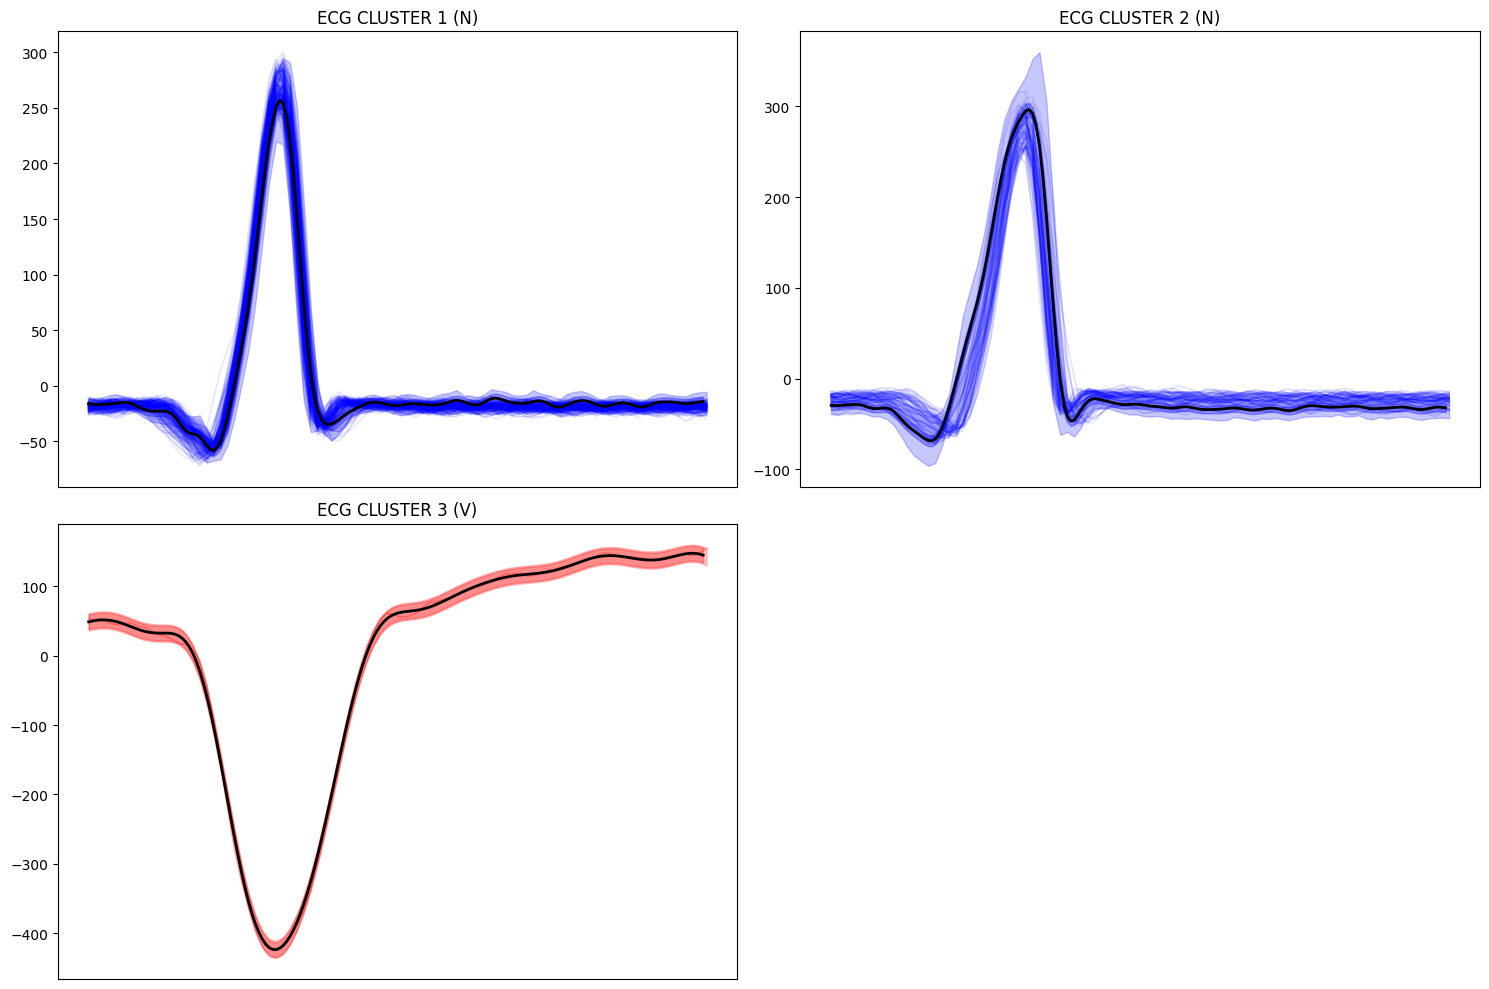

In [18]:
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

As expected, the ventricular beat generated a cluster itself.

To perform the same clustering but in an offline scheme, we only have to choose the offline inference method, we are going to use it with full record. Here are some new option parameters: reestimate_initial_params indicates when a reestimation for the prior LDS is desired (it is recommended in the offline setting), n_explore_steps indicates the number of tryals to generate a new group on each iteration, recommended is above 10, but in this case to make the clustering faster, 3 will be enough. This full clustering takes a bit longer.

In [19]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma_, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, reestimate_initial_params=True,
                          n_explore_steps=3)

data = np.load(os.path.join(data_path, '100.npy'))[:,:,[0]]
labels = np.load(os.path.join(data_path, '100_labels.npy'))
num_samples = data.shape[0]
x_trains = np.array([x_train] * num_samples)
sw_gp.include_batch(x_trains, data)


Redefining default LDS priors.
-----------Reestimated -----------
Sigma:  tensor(13.1431)
Gamma:  tensor(17.2435)
-----------------------------
Group responsability estimated: [2272    0]


Forward_pass:   0%|          | 0/2272 [00:00<?, ?it/s]


 Fitting_GP: 

Iter 1/4000 - Loss: 393.095
Iter 501/4000 - Loss: 26.934
Iter 1001/4000 - Loss: 19.495
Iter 1501/4000 - Loss: 16.023
Iter 2001/4000 - Loss: 13.870
Iter 2501/4000 - Loss: 12.346
Iter 3001/4000 - Loss: 11.183
Iter 3501/4000 - Loss: 10.249


Forward_pass:   1%|          | 17/2272 [00:16<25:22,  1.48it/s]  



Parameter name: likelihood.noise_covar.raw_noise           value = [4.3597213]
Parameter name: mean_module.raw_constant                   value = -0.4796657806582404
Parameter name: covar_module.raw_outputscale               value = 44.60223786532111
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[2.42410635]]


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1262.79it/s]



-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1340.84it/s]


Step 1/3- Trying to divide: 0 with beat 1906


Compute_sq_error: 100%|██████████| 2272/2272 [00:04<00:00, 520.27it/s] 


Sum resp_temp: tensor([2.2710e+03, 1.0000e+00])
Q_bas: tensor(-123598.1928)
Q_bas_post: tensor(-123381.7616)
Chosen to divide: 0 with beat 1906
First resp: tensor([2.2710e+03, 1.0000e+00])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([2.2710e+03, 1.0000e+00])
ELBO_reduction: 0.0
Mean_sq: tensor(-123381.7616)
ELBO: tensor([-257489.3034])

-------Lower Bound Iteration 1-------
Group responsability estimated: [2271    1]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 1093.13it/s]



-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------
Sum resp_temp: tensor([2.2710e+03, 1.0000e+00, 0.0000e+00])
Q_bas: tensor(-123381.7616)
Q_bas_post: tensor(-123381.7616)
Not reallocating, trying to generate new group.
Step 1/3- Trying to divide: 0 with beat 455


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 1040.69it/s]


Sum resp_temp: tensor([2.1180e+03, 1.5300e+02, 1.0000e+00])
Q_bas: tensor(-123381.7616)
Q_bas_post: tensor(-122446.9327)
Chosen to divide: 0 with beat 455
First resp: tensor([2.1180e+03, 1.5300e+02, 1.0000e+00])

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------

   -----------Model 3-----------
Current resp: tensor([2.1180e+03, 1.5300e+02, 1.0000e+00])
ELBO_reduction: 0.0
Mean_sq: tensor(-122446.9327)
ELBO: tensor([-254795.1294])

-------Lower Bound Iteration 2-------
Group responsability estimated: [2118  153    1]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:03<00:00, 709.02it/s] 



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 972.71it/s] 



   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 879.91it/s] 



   -----------Model 3-----------

   -----------Model 4-----------
Sum resp_temp: tensor([1.6440e+03, 6.2700e+02, 1.0000e+00, 0.0000e+00])
Q_bas: tensor(-122446.9327)
Q_bas_post: tensor(-124467.1033)
Not reallocating, trying to generate new group.
Step 1/3- Trying to divide: 0 with beat 1938


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1257.91it/s]


Sum resp_temp: tensor([1.5120e+03, 5.0500e+02, 2.5400e+02, 1.0000e+00])
Q_bas: tensor(-122446.9327)
Q_bas_post: tensor(-122843.5710)
Step 2/3- Trying to divide: 0 with beat 1795


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1386.54it/s]


Sum resp_temp: tensor([1.5460e+03, 3.7000e+02, 3.5500e+02, 1.0000e+00])
Q_bas: tensor(-122446.9327)
Q_bas_post: tensor(-122477.8255)
Step 3/3- Trying to divide: 0 with beat 1666


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 907.23it/s] 


Sum resp_temp: tensor([1.5540e+03, 4.0500e+02, 3.1200e+02, 1.0000e+00])
Q_bas: tensor(-122446.9327)
Q_bas_post: tensor(-122539.3409)
First resp: tensor([2.1180e+03, 1.5300e+02, 1.0000e+00, 0.0000e+00])
Mean_sq: tensor(-122446.9327)
ELBO: tensor([-254767.3758])

-------Lower Bound Iteration 3-------
Group responsability estimated: [2118  153    1    0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 1085.32it/s]



-----------Lead 1-----------

   -----------Model 1-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1359.24it/s]



   -----------Model 2-----------


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1332.99it/s]



   -----------Model 3-----------

   -----------Model 4-----------
Sum resp_temp: tensor([1.6440e+03, 6.2700e+02, 1.0000e+00, 0.0000e+00])
Q_bas: tensor(-122446.9327)
Q_bas_post: tensor(-124467.1033)
Not reallocating, trying to generate new group.
Step 1/3- Trying to divide: 0 with beat 1938


Compute_sq_error: 100%|██████████| 2272/2272 [00:01<00:00, 1207.25it/s]


Sum resp_temp: tensor([1.5120e+03, 5.0500e+02, 2.5400e+02, 1.0000e+00])
Q_bas: tensor(-122446.9327)
Q_bas_post: tensor(-122843.5710)
Step 2/3- Trying to divide: 0 with beat 1795


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 844.98it/s] 


Sum resp_temp: tensor([1.5470e+03, 3.6900e+02, 3.5500e+02, 1.0000e+00])
Q_bas: tensor(-122446.9327)
Q_bas_post: tensor(-122479.5838)
Step 3/3- Trying to divide: 0 with beat 1666


Compute_sq_error: 100%|██████████| 2272/2272 [00:02<00:00, 1007.55it/s]


Sum resp_temp: tensor([1.5540e+03, 4.0500e+02, 3.1200e+02, 1.0000e+00])
Q_bas: tensor(-122446.9327)
Q_bas_post: tensor(-122539.3409)
First resp: tensor([2.1180e+03, 1.5300e+02, 1.0000e+00, 0.0000e+00])
Mean_sq: tensor(-122446.9327)
ELBO: tensor([-254767.3758])

-------Lower Bound Iteration 4-------
